69950.07115288639


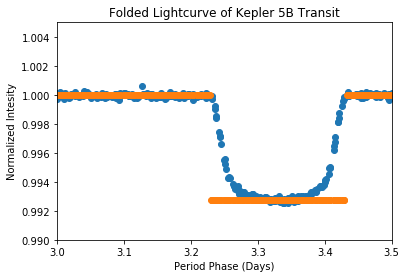

In [29]:
'''
ASTP-720, Fall 2020
Homework 7
Zach Diermyer
Problem 1 & Bonus
'''

import numpy as np
import matplotlib.pyplot as plt

def FindRadius(I, deltaI):
    '''
    Finds the radius of a transiting planet given the star's intensity and the change
    in intensity
    Inputs:
        I - Star intensity
        deltaI - Change in star's intensity
    Returns:
        Rp - Radius of the planet
    '''
    Rsun = 6.96e10  #Solar radius in cm
    Rstar = 1.79*Rsun
    squared = (deltaI/I)*Rstar**2
    Rp = (squared)**(1/2)
    return(Rp)

def ChiSquare(data, signal, error):
    '''
    Finds the chi-square value using input data and model values
    Inputs:
        data - Array of data intensity values
        signal - Array of model intensity values
        error - Array of data errors
    Returns:
        chi - Chi-square value
    '''
    if len(data) != len(signal):
        raise ValueError('Model and Data Arrays are not Equal Length')
    chi = 0
    for i in range(len(data)):
        chi += ((data[i] - signal[i])/error[i])**2
    return(chi)

def RMS(times, data, P, I, lim):
    RMS = 0
    count = 0
    for i in range(len(times)):
        if times[i] % P < lim:
            RMS += ((I - data[i])**2)**(1/2)
            count += 1
    return(RMS/count)

def CreateModel(times, P, w, tref, I, deltaI):
    '''
    Creates a boxcar intensity model for planetary transit using the input parameters
    Inputs:
        times - Time values to solve for model intensities
        P - Period of orbiting planet in days
        w - Width of drop in intensity; time planet is in front of star in days
        tref - Starting phase of planet passing in front of star
        I - Intensity of star
        deltaI - Drop in intensity due to planet passing in front of star
    Returns:
        model - Array of model values corresponding to each input time value
    '''
    enter = tref
    exit = tref + w
    model = []
    for i in range(len(times)):
        t = times[i] % P
        if t < enter:
            model.append(I)
        elif t > exit:
            model.append(I)
        else:
            model.append(I-deltaI)
    return(model)

def MetropolisHastings(P, wguess, trefguess, I, deltaIguess):
    
    return()

def main():
    data = open('lightcurve_data.txt', 'r')
    time = []
    phase = []
    flux = []
    P = 3.5485   #Period in days
    I = 1.0   #Normalized intensity
    while True:
        line = data.readline()
        if not line:
            break               #Exit if line is empty
        splitline = line.split()
        if splitline[0][0] == '#':
            pass
        else:
            time.append(float(splitline[0])-2400000.5)   #Convert from JD to MJD
            phase.append(time[-1] % P)
            flux.append(float(splitline[1]))
    sigma = RMS(times = time, data = flux, P = P, I = I, lim = 3.2)
    error = []
    for i in range(len(flux)):
        error.append(sigma)
    plt.figure(1)
    plt.scatter(phase, flux)
    plt.ylim(0.990, 1.005)
    plt.xlim(3.0, 3.5)
    plt.title('Folded Lightcurve of Kepler 5B Transit')
    plt.ylabel('Normalized Intesity')
    plt.xlabel('Period Phase (Days)')
    model = CreateModel(times = time, P = P, w = 0.2, tref = 3.23, I = I, deltaI = 0.00725)
    print(ChiSquare(data = flux, signal = model, error = error))
    plt.scatter(phase, model)
main()